# Fixing PCAP issues in CIC-IDS-2017

## Download the original CIC-IDS-2017 PCAP files

In [1]:
import os
import requests
from bs4 import BeautifulSoup

BASE_URL = 'TODO' # You can obtain the link for 'CIC-IDS-2017/Dataset/PCAPs/' through https://www.unb.ca/cic/datasets/ids-2017.html
SAVE_DIR = 'PCAP/original'

# Ensure directory exists
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Fetch the content of the webpage
response = requests.get(BASE_URL)
soup = BeautifulSoup(response.content, 'html.parser')

# Extract the .pcap file URLs and download them
for link in soup.find_all('a', href=True):
    file_url = link['href']
    
    if file_url.endswith('.pcap'):
        print(f"Downloading {file_url} ...")
        
        full_url = os.path.join(BASE_URL, file_url)
        
        response = requests.get(full_url, stream=True)
        if response.status_code == 200:
            file_path = os.path.join(SAVE_DIR, file_url)
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"... {file_url} downloaded to {SAVE_DIR}")
        else:
            print(f"Failed to download {file_url}.")

print("All downloads completed.")

... Friday-WorkingHours.pcap downloaded to PCAP/original
... Monday-WorkingHours.pcap downloaded to PCAP/original
... Thursday-WorkingHours.pcap downloaded to PCAP/original
... Tuesday-WorkingHours.pcap downloaded to PCAP/original
... Wednesday-WorkingHours.pcap downloaded to PCAP/original
All downloads completed.


## Remove duplicate packets and fix packet orders

In [2]:
%%bash

#!/bin/bash

# Define the directories
input_dir="./PCAP/original"
deduplicated_dir="./PCAP/deduplicated_only"
reordered_dir="./PCAP/deduplicated_reordered"

# Create the directories if they do not exist
mkdir -p "$deduplicated_dir" "$reordered_dir"

# Define the log file
logfile="PCAP/prepare-pcap.log"

# Clear the contents of the log file
: > $logfile

# Loop over all PCAP files in the input directory
for file in "$input_dir"/*.pcap
do
    # Extract the base filename without directory and extension
    basefile=$(basename "$file" .pcap)

    # Remove everything after the dash (including the dash)
    basefile=${basefile%%-*}

    echo "Processing file $file" | tee -a $logfile

    # Run editcap on the file, output to the deduplicated directory
    echo "Running editcap..." | tee -a $logfile
    editcap -D 10000 "$file" "$deduplicated_dir/d$basefile.pcap" >> $logfile 2>&1
    # editcap -d "$file" "$deduplicated_dir/d$basefile.pcap" >> $logfile 2>&1

    # Run reordercap on the file, output to the reordered directory
    echo "Running reordercap..." | tee -a $logfile
    reordercap "$deduplicated_dir/d$basefile.pcap" "$reordered_dir/rd$basefile.pcap" >> $logfile 2>&1

    echo "Done processing file" | tee -a $logfile
    echo "-----" | tee -a $logfile
done

echo "All done" | tee -a $logfile

Processing file ./PCAP/original/Friday-WorkingHours.pcap
Running editcap...
Running reordercap...
Done processing file
-----
Processing file ./PCAP/original/Monday-WorkingHours.pcap
Running editcap...
Running reordercap...
Done processing file
-----
Processing file ./PCAP/original/Thursday-WorkingHours.pcap
Running editcap...
Running reordercap...
Done processing file
-----
Processing file ./PCAP/original/Tuesday-WorkingHours.pcap
Running editcap...
Running reordercap...
Done processing file
-----
Processing file ./PCAP/original/Wednesday-WorkingHours.pcap
Running editcap...
Running reordercap...
Done processing file
-----
All done


## Generate packet-level stats

In [3]:
%%bash

#!/bin/bash

# Define the directories
input_dir="./PCAP/deduplicated_reordered"
output_dir="./PCAP/stats/packet-stats"

# Create the directories if they do not exist
mkdir -p "$output_dir"

# Define the log file
logfile="./PCAP/stats/packet-stats.log"

# Clear the contents of the log file
: > $logfile

# Loop over all PCAP files in the input directory
for file in "$input_dir"/*.pcap
do
    # Extract the base filename without directory and extension
    basefile=$(basename "$file" .pcap)

    echo "Processing file $file" | tee -a $logfile

    # Run capinfos on the file, output to the packet-stats directory
    capinfos -L $file > "$output_dir/$basefile-pcap-info.txt"

    # Adding headers to the CSV
    printf 'ip_proto,ip_len,ip_hdr_len,tcp_len,tcp_hdr_len,udp_length\n' > "$output_dir/$basefile-packet-stats.csv"

    # Run tshark on the file, output to the packet-stats directory
    tshark -n -r "$file" -T fields \
      -e ip.proto \
      -e ip.len \
      -e ip.hdr_len \
      -e tcp.len \
      -e tcp.hdr_len \
      -e udp.length \
      -E separator=',' -E occurrence=l >> "$output_dir/$basefile-packet-stats.csv"

    echo "Done processing the file" | tee -a $logfile
    echo "-----" | tee -a $logfile
done

echo "All done" | tee -a $logfile

# ip.len includes the IP header
# tcp.len does not include the TCP header, can have variable header lengths
# udp.length includes the UDP header

Processing file ./PCAP/deduplicated_reordered/rdFriday.pcap
Done processing the file
-----
Processing file ./PCAP/deduplicated_reordered/rdMonday.pcap
Done processing the file
-----
Processing file ./PCAP/deduplicated_reordered/rdThursday.pcap
Done processing the file
-----
Processing file ./PCAP/deduplicated_reordered/rdTuesday.pcap
Done processing the file
-----
Processing file ./PCAP/deduplicated_reordered/rdWednesday.pcap
Done processing the file
-----
All done


## Plott packet-level CDFs using the stats

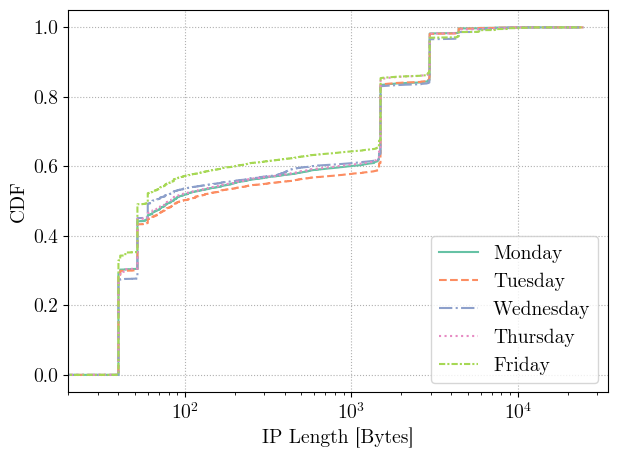

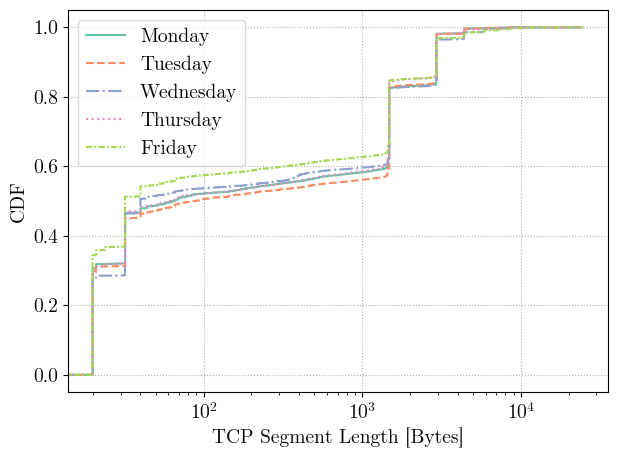

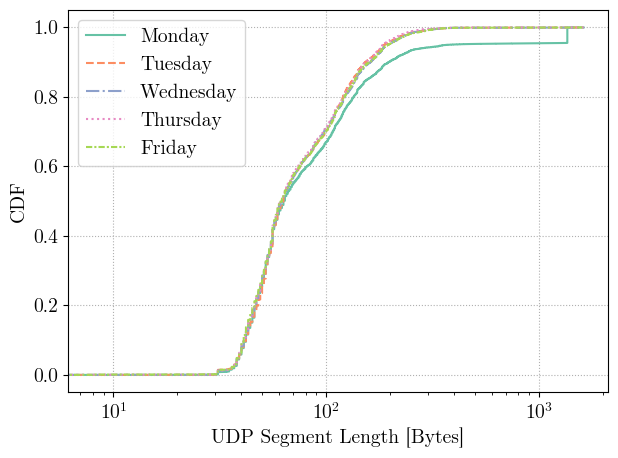

In [4]:
import re
import pandas as pd
import os
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import seaborn as sns

# Create the directory if it doesn't exist
if not os.path.exists('PCAP/stats/packet-CDF-plots'):
    os.makedirs('PCAP/stats/packet-CDF-plots')

def plot_ecdf(data, label, linestyle, color):
    plt.plot(data.x, data.y, label=label, color=color, ls=linestyle)
    plt.grid(True)

def configure_plot(font_family="CMU Serif", font_size=14):
    plt.rc('grid', linestyle=":")
    plt.rc('text', usetex=False)
    plt.rcParams["font.family"] = font_family
    plt.rcParams.update({"font.size": font_size})

def main(legend_labels=None):
    path_in = "./PCAP/stats/packet-stats/"
    path_out = "./PCAP/stats/packet-CDF-plots/"

    csv_files = [f for f in os.listdir(path_in) if f.endswith('.csv')]
    csv_files.sort()

    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
    colors = sns.color_palette('Set2', len(csv_files))

    configure_plot()

    metrics = [('ip_len', 'IP Length [Bytes]', 'ip_len'),
               ('tcp_len', 'TCP Segment Length [Bytes]', 'tcp_len + tcp_hdr_len'),
               ('udp_len', 'UDP Segment Length [Bytes]', 'udp_length')]
  
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    csv_files = sorted(csv_files, key=lambda x: day_order.index(re.search(r"rd(.*)-packet-stats.csv", x).group(1)))


    for metric_name, xlabel, expression in metrics:
        plt.figure()
        for i, csv_file in enumerate(csv_files):
            data = pd.read_csv(path_in + csv_file, sep=",", skip_blank_lines=False)
            data = data[data['ip_proto'].isin([6, 17])]
            data = data.dropna(subset=['ip_len'])
            label = legend_labels[i] if legend_labels else csv_file
            if metric_name == 'tcp_len':
                data = data[data['ip_proto'] == 6] # Only TCP
                data[metric_name] = data.eval(expression)
            elif metric_name == 'udp_len':
                data = data[data['ip_proto'] == 17] # Only UDP
                data[metric_name] = data[expression]
            plot_ecdf(ECDF(data[metric_name]), label, linestyles[i % len(linestyles)], colors[i % len(colors)])
        plt.xscale('log')
        plt.xlabel(xlabel)
        plt.ylabel('CDF')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.savefig(path_out + f'all-days-{metric_name}-cdf.png', format='png', dpi=300)

if __name__ == "__main__":
    main(
        legend_labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    )

### <span style="color:red;"> The deduplicated and reordered PCAPs to be used as input for flow generation are stored in the `PCAP/deduplicated_reordered` folder.</span>

### <span style="color:red;"> PCAP processing logs and stats are stored in the `PCAP/stats` folder.</span>